In [2]:
import pandas as pd
from prophet import Prophet

In [3]:
sales_data = pd.read_csv('duehdkk34ibnv_public_sales_orders5.csv')

sales_data.head()

,order_id,status,channel,created_at,price_incl,payment_status
0,275621306,processing_awaiting_shipment,api,2024-06-23 21:34:06.000000 +00:00,22.95,paid
1,275620303,processing_awaiting_shipment,api,2024-06-23 21:12:07.000000 +00:00,29.95,paid
2,275619961,processing_awaiting_shipment,api,2024-06-23 21:06:07.000000 +00:00,65.90,paid
3,275619018,processing_awaiting_shipment,api,2024-06-23 20:50:10.000000 +00:00,32.95,paid
4,275618179,processing_awaiting_shipment,api,2024-06-23 20:38:07.000000 +00:00,19.95,paid


In [4]:
campaign_data = pd.read_csv('ad_result.csv')

campaign_data.head()

,Date,Impressions,Clicks,CTR,Conversion,GMV (€),Spent (€),Acos (%) (€),Roas (%)
0,2023-10-23,6760,284,4.20,33,864.40,58.35,6.75,1481.41
1,2023-10-24,9298,311,3.35,33,823.40,64.01,7.77,1286.36
2,2023-10-25,4885,193,3.95,21,583.95,51.68,8.85,1129.93
3,2023-10-26,4748,214,4.51,25,637.75,45.25,7.10,1409.39
4,2023-10-27,5092,192,3.77,27,701.65,39.55,5.64,1774.08


In [5]:
weather_data = pd.read_csv('weather_data4.csv')

weather_data.head()

,Date,Temperature,Precipitation
0,2017-02-02,8.5,0.843
1,2017-02-03,8.8,0.611
2,2017-02-04,5.6,3.306
3,2017-02-05,4.4,5.623
4,2017-02-06,4.1,0.026


In [6]:
filtered_df = sales_data[(sales_data['channel'] == 'api') &
                         (sales_data['payment_status'] == 'paid') &
                         (sales_data['status'].isin(['processing_awaiting_shipment', 'completed_shipped', 'completed']))]

In [7]:
filtered_df['created_at'] = pd.to_datetime(filtered_df['created_at']).dt.date
campaign_data['Date'] = pd.to_datetime(campaign_data['Date']).dt.date
weather_data['Date'] = pd.to_datetime(weather_data['Date']).dt.date

C:\Users\vando\AppData\Local\Temp\ipykernel_7088\3915037826.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['created_at'] = pd.to_datetime(filtered_df['created_at']).dt.date


In [8]:
start_date = max(filtered_df['created_at'].min(), weather_data['Date'].min())
filtered_df = filtered_df[filtered_df['created_at'] >= start_date]
weather_data = weather_data[weather_data['Date'] >= start_date]

In [9]:
ad_start_date = pd.to_datetime('2023-10-23').date()
filtered_df['Advertisement'] = filtered_df['created_at'].apply(lambda x: 1 if x >= ad_start_date else 0)

In [10]:
daily_sales = filtered_df.groupby('created_at')['price_incl'].sum().reset_index()
daily_sales.columns = ['ds', 'y']

In [11]:
campaign_data.rename(columns={'Date': 'ds', 'Spent (€)': 'spent'}, inplace=True)
weather_data.rename(columns={'Date': 'ds'}, inplace=True)

In [12]:
combined_data = pd.merge(daily_sales, campaign_data[['ds', 'spent', 'Impressions', 'Clicks', 'CTR', 'Conversion']], on='ds', how='left')
combined_data = pd.merge(combined_data, weather_data[['ds', 'Temperature', 'Precipitation']], on='ds', how='left')


In [13]:
combined_data = pd.merge(combined_data, filtered_df[['created_at', 'Advertisement']].rename(columns={'created_at': 'ds'}), on='ds', how='left')

In [14]:
combined_data.fillna(0, inplace=True)

In [16]:
holidays = pd.DataFrame({
    'holiday': ['Black Friday'] * 7 + ['Christmas'] * 35,
    'ds': pd.to_datetime([
        '2017-11-24', '2018-11-23', '2019-11-29', '2020-11-27', '2021-11-26', '2022-11-25', '2023-11-24',
        '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-26', '2017-12-27',
        '2018-12-23', '2018-12-24', '2018-12-25', '2018-12-26', '2018-12-27',
        '2019-12-23', '2019-12-24', '2019-12-25', '2019-12-26', '2019-12-27',
        '2020-12-23', '2020-12-24', '2020-12-25', '2020-12-26', '2020-12-27',
        '2021-12-23', '2021-12-24', '2021-12-25', '2021-12-26', '2021-12-27',
        '2022-12-23', '2022-12-24', '2022-12-25', '2022-12-26', '2022-12-27',
        '2023-12-23', '2023-12-24', '2023-12-25', '2023-12-26', '2023-12-27'
    ]),
    'lower_window': [0] * 42,
    'upper_window': [0] * 42,
})

future_holidays = pd.DataFrame({
    'holiday': ['Black Friday'] * 3 + ['Christmas'] * 5,
    'ds': pd.to_datetime([
        '2024-11-29', '2025-11-28', '2026-11-27',
        '2024-12-23', '2024-12-24', '2024-12-25', '2024-12-26', '2024-12-27'
    ]),
    'lower_window': [0] * 8,
    'upper_window': [0] * 8,
})

holidays = pd.concat([holidays, future_holidays])

In [17]:
model = Prophet(holidays=holidays, yearly_seasonality=False)
model.add_seasonality(name='yearly', period=365.25, fourier_order=5)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

In [18]:
model.add_regressor('spent')
model.add_regressor('Impressions')
model.add_regressor('Clicks')
model.add_regressor('CTR')
model.add_regressor('Conversion')
model.add_regressor('Temperature')
model.add_regressor('Precipitation')
model.add_regressor('Advertisement')

In [19]:
covid_start_date = pd.to_datetime('2020-03-01').date()
covid_end_date = pd.to_datetime('2021-06-30').date()

In [20]:
combined_data['COVID_Impact'] = combined_data['ds'].apply(lambda x: 1 if covid_start_date <= x <= covid_end_date else 0)
model.add_regressor('COVID_Impact')

In [21]:
model.fit(combined_data)

08:43:18 - cmdstanpy - INFO - Chain [1] start processing
08:45:43 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
future_dates = model.make_future_dataframe(periods=60)

In [23]:
future_dates['spent'] = combined_data['spent'].mean()
future_dates['Impressions'] = combined_data['Impressions'].mean()
future_dates['Clicks'] = combined_data['Clicks'].mean()
future_dates['CTR'] = combined_data['CTR'].mean()
future_dates['Conversion'] = combined_data['Conversion'].mean()
future_dates['Temperature'] = combined_data['Temperature'].mean()
future_dates['Precipitation'] = combined_data['Precipitation'].mean()
future_dates['Advertisement'] = 1
future_dates['COVID_Impact'] = 0

In [24]:
forecast = model.predict(future_dates)

c:\Users\vando\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\vando\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
c:\Users\vando\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series cont

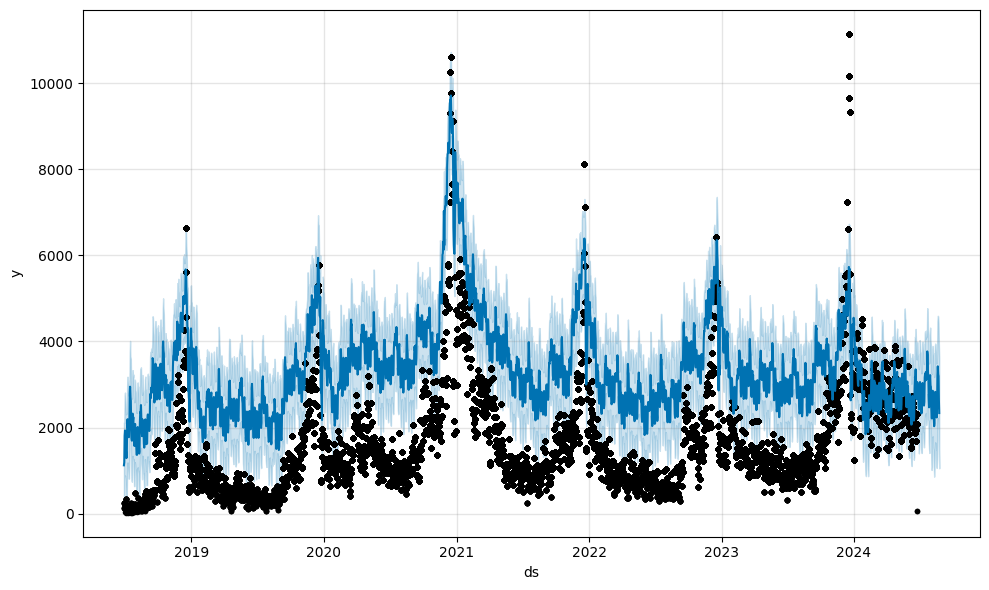

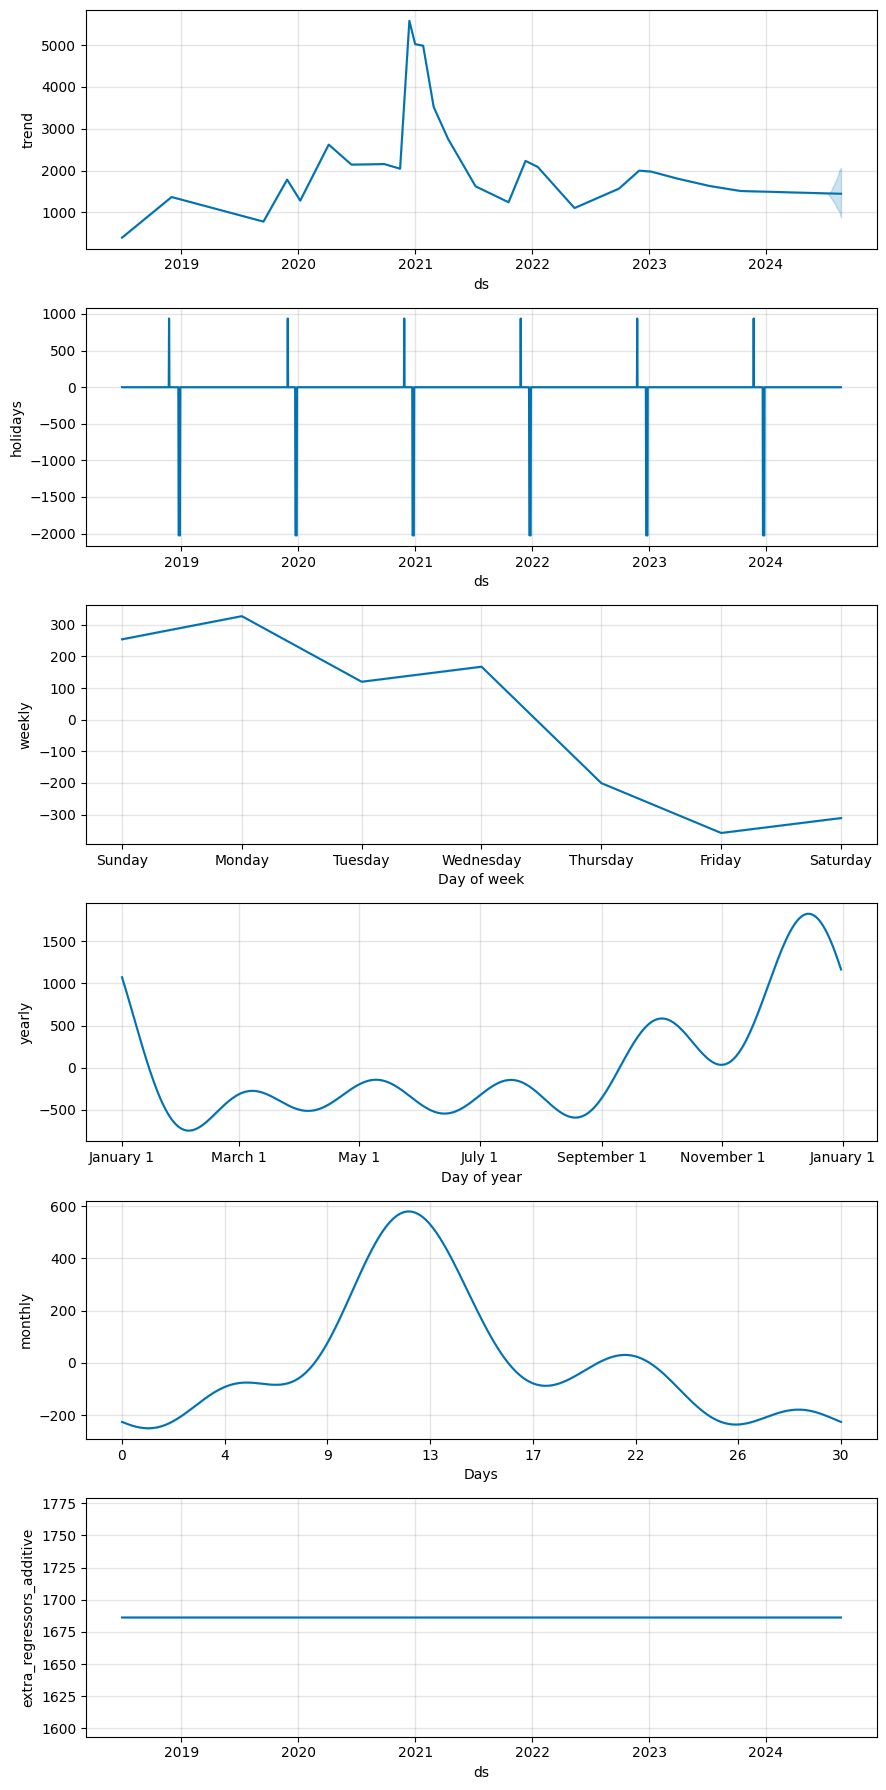

In [25]:
fig = model.plot(forecast)
fig_components = model.plot_components(forecast)

In [26]:
from prophet.diagnostics import cross_validation, performance_metrics

df_cv = cross_validation(model, initial='365 days', period='180 days', horizon='60 days')
df_performance = performance_metrics(df_cv)
print(df_performance)

# Extract and print the forecasted revenue
predicted_revenue = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
print(predicted_revenue)

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/10 [00:00<?, ?it/s]

08:48:24 - cmdstanpy - INFO - Chain [1] start processing
08:48:32 - cmdstanpy - INFO - Chain [1] done processing
08:48:33 - cmdstanpy - INFO - Chain [1] start processing
08:48:57 - cmdstanpy - INFO - Chain [1] done processing
08:48:59 - cmdstanpy - INFO - Chain [1] start processing
08:49:39 - cmdstanpy - INFO - Chain [1] done processing
08:49:41 - cmdstanpy - INFO - Chain [1] start processing
08:50:44 - cmdstanpy - INFO - Chain [1] done processing
08:50:46 - cmdstanpy - INFO - Chain [1] start processing
08:51:57 - cmdstanpy - INFO - Chain [1] done processing
08:52:01 - cmdstanpy - INFO - Chain [1] start processing
08:53:29 - cmdstanpy - INFO - Chain [1] done processing
08:53:32 - cmdstanpy - INFO - Chain [1] start processing
08:55:07 - cmdstanpy - INFO - Chain [1] done processing
08:55:11 - cmdstanpy - INFO - Chain [1] start processing
08:57:06 - cmdstanpy - INFO - Chain [1] done processing
08:57:10 - cmdstanpy - INFO - Chain [1] start processing
08:59:16 - cmdstanpy - INFO - Chain [1]

   horizon           mse         rmse          mae      mape     mdape  \
0   8 days  1.822028e+05   426.852229   351.707766  0.201393  0.165716   
1   9 days  1.928867e+05   439.188702   352.457312  0.199035  0.163469   
2  10 days  2.262135e+05   475.619041   376.425602  0.203166  0.176043   
3  11 days  2.740742e+05   523.520966   415.199971  0.218882  0.200883   
4  12 days  3.848202e+05   620.338752   478.088173  0.241908  0.201982   
5  13 days  4.498928e+05   670.740451   526.449819  0.255345  0.237681   
6  14 days  5.479317e+05   740.224117   568.647670  0.269343  0.258603   
7  15 days  6.854150e+05   827.897965   615.326467  0.270310  0.249300   
8  16 days  8.212847e+05   906.247583   684.357056  0.295325  0.258603   
9  17 days  1.049867e+06  1024.630388   766.505308  0.325740  0.304819   
10 18 days  1.296714e+06  1138.733654   847.797368  0.342862  0.333627   
11 19 days  1.610274e+06  1268.965814   937.308162  0.360540  0.333627   
12 20 days  1.732919e+06  1316.403675 